In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
from numpy import pi

# TSP problem

# TSP
## Intro to problem
What is the most efficient way to travel between points in Euclidian space? This is the problem described by the traveling salesmen problem (TSP) and if it can be solved in a favorable time (favorable being relative to those facing the problem) it can be the difference between success and failure. 

The problem was described in a 1832 German handbook for traveling salesmen "Der Handlungsreisende – wie er sein soll und was er zu thun hat, um Aufträge zu erhalten und eines glücklichen Erfolgs in seinen Geschäften gewiß zu sein – von einem alten Commis-Voyageur". The problem being if you are a traveling salesman and need to travel to a series of cities how should you travel to all of the cities and return to your home city without hitting the same city twice in the most efficient way? This problem can be abstracted into a graph problem such that cities are the graph's vertices, paths are the graph's edges, and a path's distance is the edge's weight. It is a minimization problem starting and finishing at a specified vertex after having visited each other vertex exactly once.
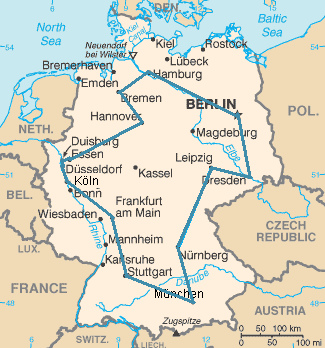

There are other applications of this problem in areas of industrial design, cable/pipe routing in buildings, DNA research, semi-conductors etc...
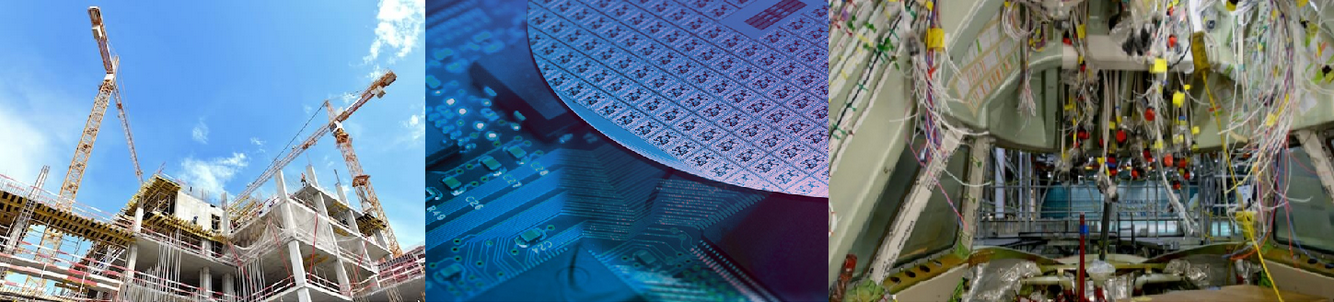

The brute force method is factorial O(N!) and is still an active area of algorithm design research. Leading algorithms are used today by companies such as Amazon for delivery truck routing and Google for Google maps routing.
## Problem Lab description
You are now an Uber driver! Your task? Travel from McDonald’s to the three deliver locations in HRM and return to McDonald’s. You are to solve this problem using the VQE method and are being provided with some functions listed below to assist you in this task. If you have a novel solution to this problem that is not using VQE exceptions can be made if you present the proposed solution to the hackathon staff before it is time to present.
## Solution description
Your solution will be a completed graph displayed using the TSPCost() function. The objective is to minimize the TSP objective displayed.
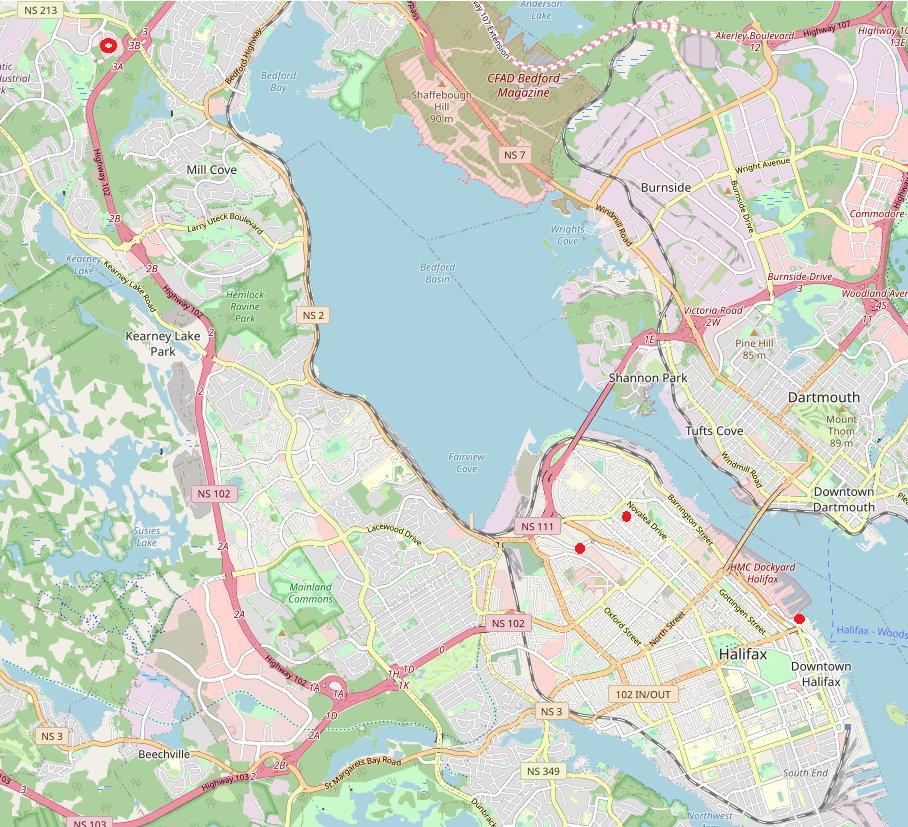 


Here is a white paper on VQE algorithms if you get stuck <br>
**[Matsuo, A., Suzuki, Y., & Yamashita, S. Problem-specific parameterized quantum circuits of the VQE algorithm for optimization problems. 2020.](https://arxiv.org/pdf/2006.05643.pdf)** **[[1]](https://arxiv.org/pdf/2006.05643.pdf)**

In [3]:
from itertools import permutations
import matplotlib.axes as axes
import matplotlib.pyplot as plt
import networkx as nx
from typing import Optional

from qiskit.algorithms import MinimumEigensolver, NumPyMinimumEigensolver, VQE
from qiskit.algorithms.minimum_eigensolvers import QAOA, SamplingVQE, VQE
from qiskit.algorithms.optimizers import L_BFGS_B, SLSQP, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.tools.visualization import plot_histogram
from qiskit.utils import algorithm_globals, QuantumInstance

from qiskit_optimization import QuadraticProgram
from qiskit.algorithms.minimum_eigen_solvers import NumPyMinimumEigensolver,  MinimumEigensolver
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator

from qiskit_aer import Aer

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_optimization.problems import QuadraticProgram
from qiskit_ibm_runtime import Session, Estimator, Sampler, Options


In [ ]:
from qiskit.exceptions import QiskitError


class QiskitOptimizationError(QiskitError):
    """Class for errors returned by Qiskit's optimization module."""

    pass

In [ ]:
import os
notebook_path = os.path.abspath("TSP.ipynb")


ca4663 = os.path.join(os.path.dirname(notebook_path), "halifax_delivy_locations.tsp")

In [ ]:
from typing import Dict, List, Optional, Union

import networkx as nx
import numpy as np
from docplex.mp.model import Model

from qiskit.utils import algorithm_globals
from qiskit_optimization.algorithms import OptimizationResult
from qiskit_optimization.exceptions import QiskitOptimizationError
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
#from .graph_optimization_application import GraphOptimizationApplication

name = ""
coord = []  # type: ignore
with open(ca4663, encoding="utf8") as infile:
    coord_section = False
    for line in infile:
        if line.startswith("NAME"):
            name = line.split(":")[1]
            name = name.strip()
        elif line.startswith("TYPE"):
            typ = line.split(":")[1]
            typ = typ.strip()
            if typ != "TSP":
                raise QiskitOptimizationError(
                    f'This supports only "TSP" type. Actual: {typ}'
                )
        elif line.startswith("EOF"):
            # End Of File tag
            break
        elif line.startswith("DIMENSION"):
            dim = int(line.split(":")[1])
            coord = np.zeros((dim, 2))  # type: ignore
        elif line.startswith("EDGE_WEIGHT_TYPE"):
            typ = line.split(":")[1]
            typ = typ.strip()
            if typ != "EUC_2D":
                raise QiskitOptimizationError(
                    f'This supports only "EUC_2D" edge weight. Actual: {typ}'
                )
        elif line.startswith("NODE_COORD_SECTION"):
            coord_section = True
        elif coord_section:
            v = line.split()
            index = int(v[0]) - 1
            coord[index][0] = float(v[1])
            coord[index][1] = float(v[2])
x_max = max(coord_[0] for coord_ in coord)
x_min = min(coord_[0] for coord_ in coord)
y_max = max(coord_[1] for coord_ in coord)
y_min = min(coord_[1] for coord_ in coord)
pos = dict(enumerate(coord))
graph = nx.random_geometric_graph(
    len(coord), np.hypot(x_max - x_min, y_max - y_min) + 1, pos=pos
)
for w, v in graph.edges:
    delta = [graph.nodes[w]["pos"][i] - graph.nodes[v]["pos"][i] for i in range(2)]
    graph.edges[w, v]["weight"] = np.rint(np.hypot(delta[0], delta[1]))

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Initialize service and backend
#QiskitRuntimeService.save_account(channel='ibm_quantum', token='my_token', overwrite=True) #uncomment if you need to save your account again
service = QiskitRuntimeService(channel="ibm_quantum")

# Set simulator
backend = service.backends(simulator=True)[0]
print(backend)

<IBMBackend('ibmq_qasm_simulator')>


In [5]:
# Draw and visualize graph solution
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=900, alpha=0.9, ax=default_axes, pos=pos, node_shape="o")
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [6]:
# Compute cost of the obtained result and display result
def TSPCost(energy, result_bitstring, adj_matrix):
    print("-------------------")
    print("Energy:", energy)
    print("Tsp objective:", energy + offset)
    print("Feasibility:", qubo.is_feasible(result_bitstring))
    
    solution_vector = tsp.interpret(result_bitstring)
    print("Solution Vector:", solution_vector)
    print("Solution Objective:", tsp.tsp_value(solution_vector, adj_matrix))
    print("-------------------")
    
    # Draw Graph
    draw_tsp_solution(tsp.graph, solution_vector, colors, pos)

In [7]:
# Plots a convergence graph
def PlotGraph(ideal, mean):
    plt.figure(figsize=(8, 6))
    # Plot label
    for value in range(len(mean)):
        plt.plot(mean[value], label="Proposal {}".format(value+1) )
        
    # Ideal plot
    plt.axhline(y=ideal, color="tab:red", ls="--", label="Target")
    plt.legend(loc="best")
    plt.xlabel("Optimizer iteration")
    plt.ylabel("Energy")
    
    # Plot graph title
    plt.title("TSP Entangler Line {} Constraint".format(len(mean)))
    plt.show()

In [8]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

distance
 [[ 0. 26. 33. 92.]
 [26.  0. 18. 68.]
 [33. 18.  0. 60.]
 [92. 68. 60.  0.]]


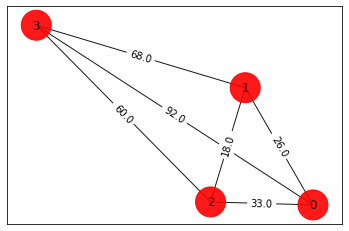

In [9]:
n = 4
num_qubits = n**2 

tsp = Tsp.create_random_instance(n, seed=74)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

In [10]:
from qiskit_optimization.converters import QuadraticProgramToQubo
qp = tsp.to_quadratic_program()



qp2qubo = QuadraticProgramToQubo()    #instatiate qp to qubo class
qubo = qp2qubo.convert(qp)      # convert quadratic program to qubo
qubitOp, offset = qubo.to_ising()      #convert qubo to ising

In [ ]:
def tsp_entangler(N):
    
    # Define QuantumCircuit and ParameterVector size
    circuit = QuantumCircuit(N**2)
    theta =  ParameterVector('theta',length=(N-1)*N)
    
     ???

    return circuit

def BestBitstring(result, optimal_circuit):
    energy = result.eigenvalue.real
    
    options = Options(simulator={"seed_simulator": 42},resilience_level=0) # Do not change and please pass it in the Sampler call for successful grading
    
    sampler = Sampler(options=options)
    duy = list(result.optimal_parameters.values())
    with Session(service = service, backend = backend):
        sampler_result = sampler.run(circuits=[optimal_circuit], parameter_values=[duy]).result()
    result_prob_dist = sampler_result.quasi_dists[0].nearest_probability_distribution()# Obtain the nearest_probability_distribution for the sampler result from the quasi distribution obtained
   
    
    max_key = format(max(result_prob_dist, key = result_prob_dist.get),"016b")

    result_bitstring = np.array(list(map(int, max_key)))
    
    return energy, sampler_result, result_prob_dist, result_bitstring



In [ ]:
def RunVQE(estimator, model, optimizer, operator, init=None):
    
    # Store intermediate results
    history = {"eval_count": [], "parameters": [], "mean": [], "metadata": []}
    
    # Define callback function
    def store_intermediate_result(eval_count, parameters, mean, metadata):
        history["eval_count"].append(eval_count)
        history["parameters"].append(parameters)
        history["mean"].append(mean.real)
    
    # Define VQE run
    vqe = VQE(estimator=estimator, ansatz=model, optimizer=optimizer, callback=store_intermediate_result, initial_point=init)


    # Compute minimum_eigenvalue
    result = vqe.compute_minimum_eigenvalue(operator)

    return result, history["mean"]

In [ ]:
theta = ParameterVector('theta',length=(n-1)*n//2)

model = QuantumCircuit(n**2)
PQC = tsp_entangler(4)

In [ ]:
# You may need to change the code below and use the given seeds for successful grading
from qiskit.utils import algorithm_globals
from qiskit.primitives import Estimator
algorithm_globals.random_seed = 

# Define optimizer
optimizer = SPSA(maxiter=150)

# Define Initial point
np.random.seed(10)
init = np.random.rand((n-1)*n) * 2 * np.pi

# Define backend
backend = service.backends(simulator=True)[0]


# Call RunVQE. Do not pass in options
with Session(service = service, backend = backend):
    result, mean = RunVQE(Estimator(),PQC,optimizer,qubitOp, init)

result.optimal_parameters
# Print result
print(result.optimal_parameters)


In [ ]:
optimal = result.optimal_circuit.measure_all(inplace=False) # Extract optimal circuit and add measurements
with Session(service=service, backend=backend):
    energy, sampler_result, result_prob_dist, result_bitstring = BestBitstring(result=result, optimal_circuit=optimal)
print("Optimal bitstring = ", result_bitstring)

In [ ]:
TSPCost(energy = energy, result_bitstring = result_bitstring, adj_matrix = adj_matrix)

In [ ]:
# Plot convergence
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)
energy_numpy = result.eigenvalue.real
# Plot convergence
PlotGraph(ideal = energy_numpy, mean = [mean])